In [ ]:
import math
import torch
from torch import nn
from torch.nn import functional as F
import traintools

In [ ]:
batch_size,num_steps = 32,35
train_iter,vocab = traintools.load_data_time_machine(batch_size, num_steps)
it = iter(train_iter)
try:
    X0, Y0 = next(it)
    print('first batch shapes:', X0.shape, Y0.shape)
except StopIteration:
    raise RuntimeError(
        "train_iter 为空。请确认 traintools.load_data_time_machine 返回的 corpus 是整数索引序列且长度足够。"
    )


In [ ]:
vocab['a']

In [ ]:
F.one_hot(torch.tensor([0, 2]), num_classes=len(vocab))

In [ ]:
X = torch.arange(10).reshape(2, 5)
print(X.T)
F.one_hot(X.T, num_classes=len(vocab))

In [ ]:



def get_params(vocab_size, num_hiddens, device):
    """
    初始化 RNN 模型所需的参数（权重和偏置），并返回参数列表。
    说明：
      - 输入和输出的维度均为 vocab_size（使用 one-hot 编码作为输入，输出为对下一个 token 的未归一化预测）
      - num_hiddens: 隐状态维度（隐藏单元数量）
      - 返回的每个参数都设置 requires_grad_(True) 以参与反向传播
    返回值 shapes：
      W_xh: (num_inputs, num_hiddens)   -- 输入到隐藏的权重
      W_hh: (num_hiddens, num_hiddens) -- 隐到隐的权重
      b_h : (num_hiddens,)             -- 隐状态偏置
      W_hq: (num_hiddens, num_outputs) -- 隐到输出的权重
      b_q : (num_outputs,)             -- 输出偏置
    """
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        # 用较小的随机值初始化权重，放到指定 device
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数：权重矩阵与偏置
    W_xh = normal((num_inputs, num_hiddens))    # 把 one-hot 输入映射到隐藏单元
    W_hh = normal((num_hiddens, num_hiddens))   # 隐状态之间的转换
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数：将隐藏态映射到词表大小的输出（用于后续 softmax / 交叉熵）
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 将参数放入列表并开启梯度记录
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params


def initial_state(batch_size, num_hiddens, device):
    """
    返回初始隐状态。
    使用元组封装以便统一处理（有些 RNN 变体需要多个张量作为状态）。
    返回值：(H,)
      H shape: (batch_size, num_hiddens)
    """
    return (torch.zeros((batch_size, num_hiddens), device=device),)


def rnn(inputs, states, params):
    """
    手工实现的简单 RNN 前向计算（按时间步循环）。
    参数:
      inputs: 时间步序列，通常形状为 (num_steps, batch_size, vocab_size)
              在调用处 inputs.T 后使用 one-hot，确保第一个维度是时间步（方便 for X in inputs 遍历）
      states: 元组，包含上一步的隐状态，例如 (H,)
      params: 参数列表 [W_xh, W_hh, b_h, W_hq, b_q]
    返回:
      outputs_concat: 将每个时间步的输出按 dim=0 连接（D2L 中常用的组织方式）
                      注意：若 inputs 长度为 num_steps，batch_size 为 B，则 outputs_concat shape 为 (num_steps * B, vocab_size)
      (H,): 最后时间步的隐状态元组，H shape 为 (batch_size, num_hiddens)
    说明计算细节：
      对单步 X（shape (batch_size, vocab_size)）:
        H = tanh(X @ W_xh + H @ W_hh + b_h)
        Y = H @ W_hq + b_q  # 未做 softmax，通常后续会配合 CrossEntropyLoss
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = states  # 解包当前隐状态，H shape: (batch_size, num_hiddens)
    outputs = []
    for X in inputs:  # X shape: (batch_size, vocab_size)
        # 更新隐状态：X 映射到隐藏，之前的 H 也映射到隐藏，二者相加并加偏置后经过 tanh
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        # 计算当前时间步的输出（未归一化的 logits）
        Y = torch.mm(H, W_hq) + b_q  # shape: (batch_size, vocab_size)
        outputs.append(Y)
    # outputs 是长度为 num_steps 的列表，每项 shape (batch_size, vocab_size)
    # torch.cat(outputs, dim=0) 将其拼成 (num_steps * batch_size, vocab_size)
    return torch.cat(outputs, dim=0), (H,)


class RNNModelScratch:
    """
    基于从零实现的 RNN 模型包装类（不使用 nn.Module）。
    输入:
      vocab_size: 词表大小（one-hot 维度）
      num_hiddens: 隐状态维度
      device: 计算设备
      get_params: 用于初始化参数的函数
      init_state: 用于初始化隐状态的函数
      forward_fn: RNN 的前向函数（如上 rnn）
    用法:
      - inputs 在 __call__ 中被视作形状 (batch_size, num_steps) 的索引张量
      - 在 __call__ 内将 inputs 转为 one-hot，并转置到 (num_steps, batch_size, vocab_size)，
        以便 forward_fn 按时间步迭代（for X in inputs）
    """
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.param = get_params(vocab_size, num_hiddens, device)
        self.init_state = init_state
        self.forward_fn = forward_fn

    def __call__(self, inputs, state):
        # inputs 期望为 (batch_size, num_steps)，每个元素为词索引
        # 转置到 (num_steps, batch_size) 后再做 one-hot，得到 (num_steps, batch_size, vocab_size)
        X = F.one_hot(inputs.T, num_classes=self.vocab_size).type(torch.float32)
        # forward_fn 期望接收 (num_steps, batch_size, vocab_size) 这样的序列形式
        return self.forward_fn(X, state, self.param)

    def begin_state(self, batch_size, device):
        # 返回初始隐状态，供训练或推理时调用
        return self.init_state(batch_size, self.num_hiddens, device)
    
    def get_params(self):
        # 返回当前模型参数列表
        return self.param


# 以下示例展示如何创建模型并做一次前向调用（保留原示例代码，仅增加注释）
num_hiddens = 512
# 创建模型实例，vocab 为词表对象，len(vocab) 即词表大小
net = RNNModelScratch(len(vocab), num_hiddens,
                      device=traintools.try_gpu(),
                      get_params=get_params,
                      init_state=initial_state,
                      forward_fn=rnn)

# state 初始化，X.shape[0] 为 batch_size（示例中 X 在前面 cell 已定义）
state = net.begin_state(X.shape[0], traintools.try_gpu())

# 将输入 X（shape: batch_size x num_steps）移动到 GPU 并调用模型
# 返回 Y 是拼接后的 logits，new_state 为最后时间步的隐状态元组
Y, new_state = net(X.to(traintools.try_gpu()), state)

# 打印形状说明：
# Y.shape   -> (num_steps * batch_size, vocab_size) （因为 rnn 返回了 cat 后的输出）
# len(new_state) -> 1 （仅一个张量 H）
# new_state[0].shape -> (batch_size, num_hiddens)

In [ ]:
def predict_ch8(prefix,num_preds,net,vocab,device):
	"""
	使用训练好的 RNN 模型 net 来预测后续词元。
	参数:
	  prefix: 用于预测的前缀字符串（至少一个字符）
	  num_preds: 需要预测的后续词元数量
	  vocab: 词表对象
	  device: 计算设备
	返回:
	  预测结果字符串
	说明:
	  - 首先将 prefix 的每个字符作为输入，更新隐状态
	  - 然后让模型继续预测 num_preds 个字符，并将其添加到输出中
	"""
	state = net.begin_state(batch_size=1, device=device)  # 初始隐状态
	outputs = [vocab[prefix[0]]]  # 输出列表，先放入 prefix 的第一个字符

	# 使用 prefix 填充隐状态
	# 即预热 Warm-up阶段
	for y in prefix[1:]:  # 遍历 prefix 除第一个字符外的其他字符
		# 将当前字符转换为张量并移动到指定设备
		X = torch.tensor([[vocab[y]]], device=device)
		# 前向计算，更新隐状态（输出 Y 不需要）
		_, state = net(X, state)
		outputs.append(vocab[y])  # 将当前字符对应的索引加入输出

	# 继续预测 num_preds 个字符
	for _ in range(num_preds):
		X = torch.tensor([[outputs[-1]]], device=device)  # 上一个预测的字符作为输入
		Y, state = net(X, state)  # 前向计算，获得输出和更新隐状态
		# 打印Y中各个字符的概率
		print(Y.softmax(dim=1))
		
		p = Y.argmax(dim=1).item()  # 取概率最高的词元索引作为预测结果
		outputs.append(p)  # 将预测结果加入输出

	return ''.join([vocab.idx_to_token[i] for i in outputs])  # 将索引转换回字符并拼接成字符串

In [ ]:
predict_ch8('time traveller ',10,net,vocab,traintools.try_gpu())

In [ ]:
import time


def grad_clip(net,theta):
	"""
	对模型参数进行梯度裁剪，以防止梯度爆炸。
	参数:
	  net: RNN 模型
	  theta: 裁剪阈值
	"""
	# 首先提取参数
	if isinstance(net, nn.Module):
		# 如果是使用nn中的模块
		params = [p for p in net.parameters() if p.requires_grad]
	elif isinstance(net, RNNModelScratch):
		params = net.get_params()

	# 计算当前参数梯度的范数
	# 这里使用L2范数
	norm = torch.sqrt(sum((p.grad ** 2).sum() for p in params if p.grad is not None))

	if norm>theta:
		# 如果范数超过阈值，则进行裁剪
		for p in params:
			if p.grad is not None:
				p.grad[:] *= theta / norm

def train_epoch_ch8(net, train_iter, loss, updater, device,use_random_iter):
	"""
	训练模型一个迭代周期。
	参数:
	  net: RNN 模型
	  train_iter: 训练数据迭代器
	  loss: 损失函数
	  updater: 优化器
	  device: 计算设备
	  use_random_iter: 是否使用随机迭代器
	"""
	start = time.time_ns()  # 记录开始时间
	state = None
	metric = traintools.Accumulator(2)  # 训练损失总和, 词元数量
	# 检查迭代器
	for X,Y in train_iter:
		print('batch shapes:', X.shape, Y.shape)
		if state is None or use_random_iter:
			# 如果是随机采样, 在每个小批量都需要初始化隐状态
			# 如果是相邻采样, 则使用上一个小批量的最终隐状态
			state = net.begin_state(batch_size=X.shape[0], device=device)
		else:
			if isinstance(net,nn.Module) and not isinstance(state,tuple):
				# state 对于nn.GRU来说是一个张量
				state.detach_()
			else:
				# 对于自定义RNN模型，state是一个元组
				for s in state:
					s.detach_()
		y = Y.T.reshape(-1)
		X,y = X.to(device), y.to(device)
		y_hat, state = net(X, state)
		l = loss(y_hat, y.long()).mean()
		# 如果使用了nn中的优化器
		if isinstance(updater, torch.optim.Optimizer):
			updater.zero_grad()
			l.backward()
			grad_clip(net,1)
			updater.step()
		else:
			# 对于自定义优化器
			# updater.zero_grad()
			l.backward()
			grad_clip(net,1)
			updater(batch_size=1)
		metric.add(l * y.numel(), y.numel())
		print(y.numel())
	end = time.time_ns()
	return math.exp(metric[0] / metric[1]),metric[1] / (end - start +1)  # 返回困惑度, 词元/秒

In [ ]:
def train_ch8(net,train_iter,vocab,lr,num_epochs,device,use_random_iter =False):
	loss = nn.CrossEntropyLoss()
	if isinstance(net,nn.Module):
		updater = torch.optim.SGD(net.parameters(), lr=lr)
	else:
		updater = lambda batch_size: traintools.sgd(net.param, lr, batch_size)
	predict = lambda prefix:predict_ch8(prefix,50, net, vocab, device)

	for epoch in range(num_epochs):
		ppl,speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
		if epoch % 10 == 0:
			print(f"epoch {epoch}, perplexity {ppl:.1f}, speed {speed:.1f} tokens/sec")

	print(f'困惑度 {ppl:.1f}, 词元/秒 {speed:.1f}')
	print(predict('time traveller '))  # 打印预测结果
	print(predict('traveller '))  # 打印预测结果



# 此行以上代码存在严重问题，弃用

In [7]:
import RNN.rnn as rnn
import torch
from torch import nn

Epoch 10, Perplexity: 13.98, Speed: 275086.66 tokens/sec
Epoch 20, Perplexity: 11.03, Speed: 270836.22 tokens/sec
Epoch 30, Perplexity: 9.56, Speed: 188772.22 tokens/sec
Epoch 40, Perplexity: 8.70, Speed: 165737.44 tokens/sec
Epoch 50, Perplexity: 7.89, Speed: 278683.03 tokens/sec
Epoch 60, Perplexity: 7.35, Speed: 270834.28 tokens/sec
Epoch 70, Perplexity: 6.27, Speed: 251515.64 tokens/sec
Epoch 80, Perplexity: 5.16, Speed: 170515.64 tokens/sec
Epoch 90, Perplexity: 4.35, Speed: 281080.03 tokens/sec
Epoch 100, Perplexity: 3.74, Speed: 270094.59 tokens/sec
Epoch 110, Perplexity: 3.27, Speed: 239098.12 tokens/sec
Epoch 120, Perplexity: 2.87, Speed: 279934.78 tokens/sec
Epoch 130, Perplexity: 2.54, Speed: 293885.97 tokens/sec
Epoch 140, Perplexity: 2.31, Speed: 280501.00 tokens/sec
Epoch 150, Perplexity: 2.13, Speed: 171154.75 tokens/sec
Epoch 160, Perplexity: 2.03, Speed: 258907.64 tokens/sec
Epoch 170, Perplexity: 1.90, Speed: 282889.06 tokens/sec
Epoch 180, Perplexity: 1.84, Speed: 24

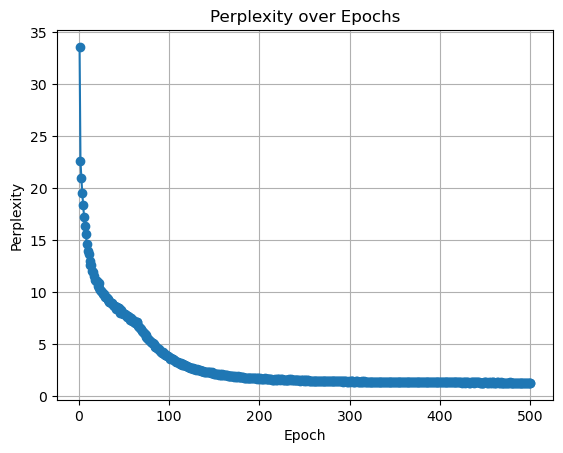

In [8]:
batch_size, num_steps = 32, 35
data_iter, vocab = rnn.load_data_time_machine(batch_size, num_steps, use_random_iter=True)
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
num_epochs,lr = 500,1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = rnn.RNNModel(rnn_layer=rnn_layer,vocab_size=len(vocab))
net = net.to(device)
rnn.train(net, data_iter, vocab,lr,num_epochs=num_epochs, device=device)